In [ ]:
!pip install pactus
!pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.5/64.5 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 68.8 MB/s eta 0:00:00


#### Library definition

In [ ]:
from pactus import Dataset, featurizers
from pactus.models import XGBoostModel
import matplotlib.pyplot as plt
import numpy as np
from yupi.graphics import plot_2d, plot_hist
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.lines as mlines

from pactus import Dataset
SEED = 0

#### Load dataset

In [ ]:
datasets = Dataset.hurdat2()

[==================================================] 100.00%


In [ ]:
print(f"Loaded dataset: {datasets.name}")
print(f"Total trajectories: {len(datasets.trajs)}")
print(f"Different classes: {datasets.classes}")

Loaded dataset: hurdat2
Total trajectories: 1903
Different classes: [1, 3, 0, 2, 4, 5]


#### First trajectories

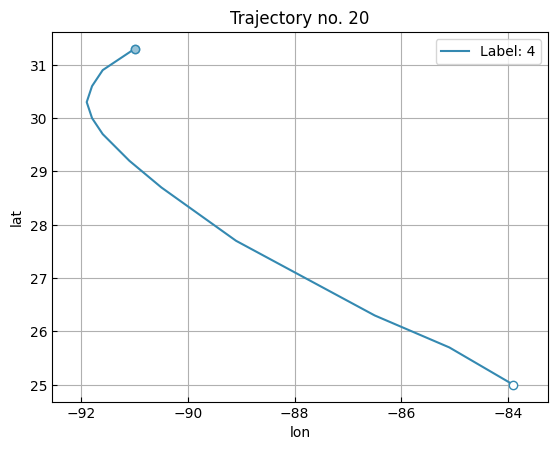

In [ ]:
traj_idx = 20
traj, label = datasets.trajs[traj_idx], datasets.labels[traj_idx]
plot_2d([traj], legend=False, show=False)
plt.legend([f"Label: {label}"])
plt.title(f"Trajectory no. {traj_idx}")
plt.xlabel("lon")
plt.ylabel("lat")
plt.show()

#### Subset of the first trajectories

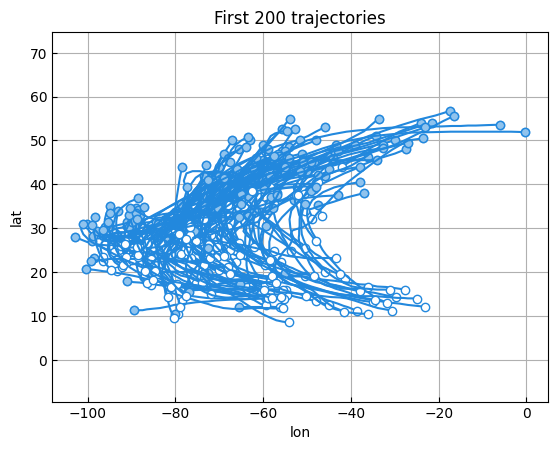

In [ ]:
traj_count = 200
first_trajs = datasets.trajs[:traj_count]
plot_2d(first_trajs, legend=False, color="#2288dd", show=False)
plt.title(f"First {traj_count} trajectories")
plt.xlabel("lon")
plt.ylabel("lat")
plt.show()

#### Distribution of trajectories on each class

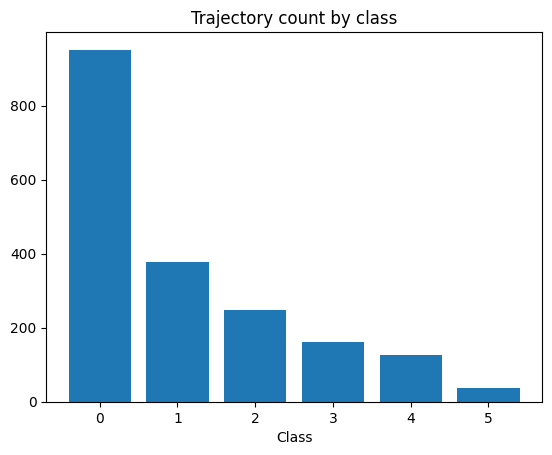

In [ ]:
plt.bar(datasets.label_counts.keys(), datasets.label_counts.values())
plt.title("Trajectory count by class")
plt.xlabel("Class")
plt.show()

#### Lenght distribution of the trajectories in the dataset

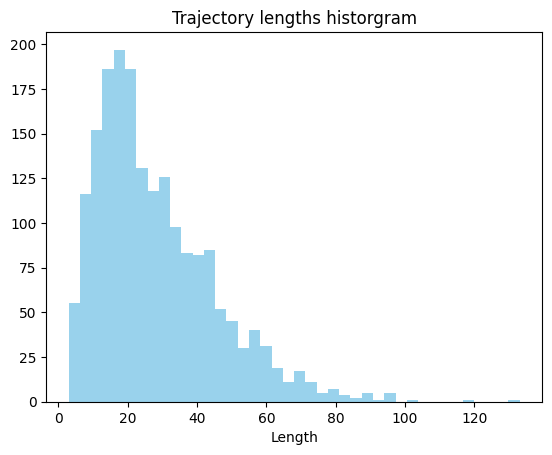

In [ ]:
lengths = np.array([len(traj) for traj in datasets.trajs])
plot_hist(lengths, bins=40, show=False)
plt.title("Trajectory lengths historgram")
plt.xlabel("Length")
plt.show()

#### Convert dataset

In [ ]:
featurizer = featurizers.UniversalFeaturizer()

#### Load and train and evaluate model

In [ ]:
print(f"\nDataset: {datasets.name}\n")

# Split the dataset into train and test and filter out short trajectories
train, test = datasets.filter(
    lambda traj, label: len(traj) >= 5
    and traj.r.delta.norm.sum() > 0
    and datasets.label_counts[label] > 5
).split(
    train_size=0.7,
    random_state=SEED,
)

# Define the model
model = XGBoostModel(featurizer=featurizer)

# Evaluate the results
model.train(data=train, cross_validation=5)
evaluation = model.evaluate(test)
evaluation.show()


Dataset: hurdat2

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ..................................., score=0.525 total time=   5.3s
[CV 2/5] END ..................................., score=0.506 total time=   3.5s
[CV 3/5] END ..................................., score=0.515 total time=   3.5s
[CV 4/5] END ..................................., score=0.462 total time=   5.0s
[CV 5/5] END ..................................., score=0.538 total time=   8.4s

General statistics:

Accuracy: 0.540
F1-score: 0.294
Mean precision: 0.304
Mean recall: 0.292

Confusion matrix:

0      1      2      3      4      5      precision
85.82  57.52  39.19  20.41  15.79  9.09   68.56  
9.57   25.66  18.92  26.53  15.79  0.0    32.58  
3.19   8.85   24.32  22.45  15.79  0.0    33.33  
1.42   3.54   10.81  18.37  31.58  18.18  23.08  
0.0    4.42   6.76   12.24  21.05  72.73  25.0   
0.0    0.0    0.0    0.0    0.0    0.0    0.0    
-------------------------------------------------


#### Plot out result vs actual

/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWar

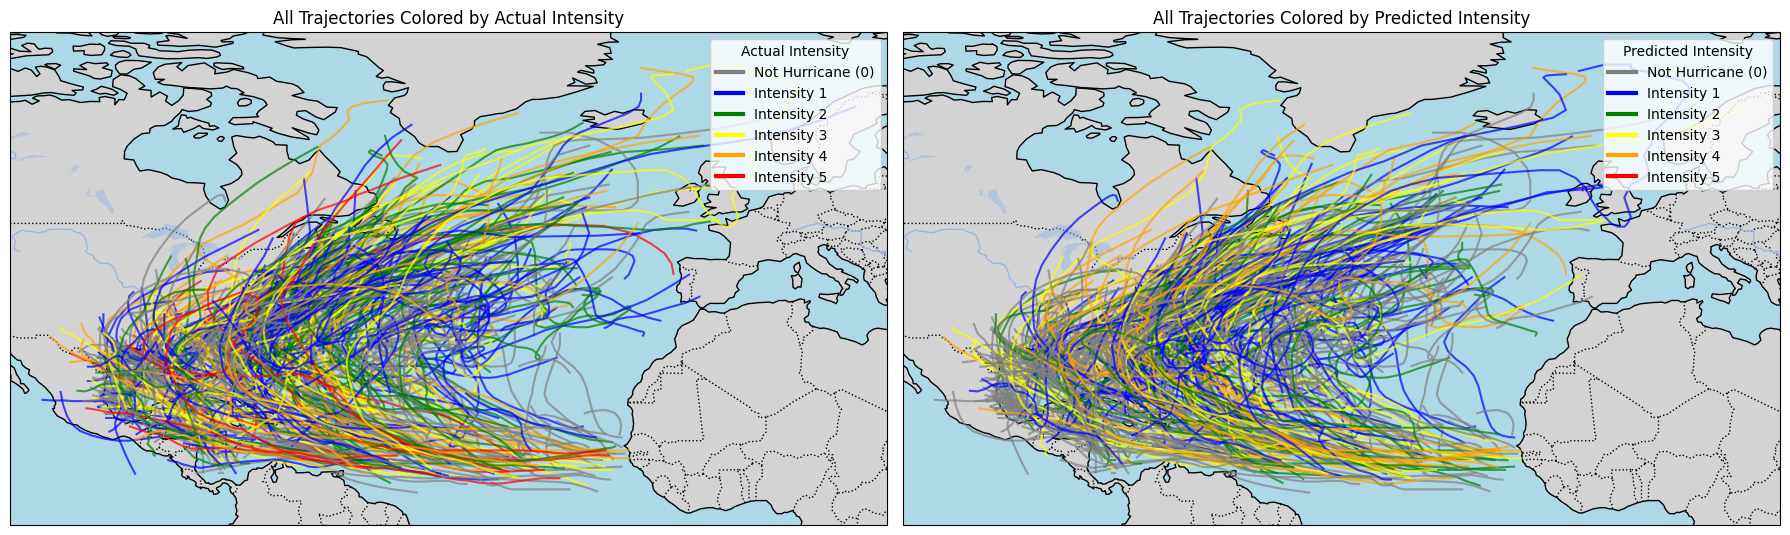

In [ ]:
predictions = model.predict(test)

# Define color mapping for the Saffir-Simpson categories (0 to 5)
intensity_colors = {
    0: 'gray',    # Not a hurricane
    1: 'blue',
    2: 'green',
    3: 'yellow',
    4: 'orange',
    5: 'red'
}

# Gather all longitudes and latitudes from test set for automatic map extent
all_lons = []
all_lats = []
for traj in test.trajs:
    all_lons.append(traj.r[:, 0])
    all_lats.append(traj.r[:, 1])

all_lons = np.concatenate(all_lons)
all_lats = np.concatenate(all_lats)

# Create a figure with two subplots: left=actual, right=predicted
fig = plt.figure(figsize=(18, 10))

# 1) Left subplot: Actual intensity
ax1 = fig.add_subplot(1, 2, 1, projection=ccrs.PlateCarree())
ax1.set_title("All Trajectories Colored by Actual Intensity")

# Set the extent so that all trajectories are visible
margin = 5
ax1.set_extent([
    all_lons.min() - margin,
    all_lons.max() + margin,
    all_lats.min() - margin,
    all_lats.max() + margin
], crs=ccrs.PlateCarree())

# Add map features
ax1.add_feature(cfeature.LAND, facecolor='lightgray')
ax1.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax1.add_feature(cfeature.COASTLINE)
ax1.add_feature(cfeature.BORDERS, linestyle=':')
ax1.add_feature(cfeature.LAKES, alpha=0.5)
ax1.add_feature(cfeature.RIVERS)

# Plot each trajectory on the left map (actual label)
for i, traj in enumerate(test.trajs):
    actual_label = test.labels[i]  # Actual intensity (0–5)
    lon = traj.r[:, 0]
    lat = traj.r[:, 1]

    color = intensity_colors.get(actual_label, 'black')
    ax1.plot(lon, lat, color=color, transform=ccrs.PlateCarree(), alpha=0.7)

# Build a legend for the left subplot (actual intensities)
legend_handles_left = []
for cat, c in intensity_colors.items():
    label_text = f'Intensity {cat}' if cat > 0 else 'Not Hurricane (0)'
    line = mlines.Line2D([], [], color=c, label=label_text, linewidth=3)
    legend_handles_left.append(line)
ax1.legend(handles=legend_handles_left, loc='upper right', title='Actual Intensity')

# 2) Right subplot: Predicted intensity
ax2 = fig.add_subplot(1, 2, 2, projection=ccrs.PlateCarree())
ax2.set_title("All Trajectories Colored by Predicted Intensity")

# Use the same extent so both subplots match
ax2.set_extent([
    all_lons.min() - margin,
    all_lons.max() + margin,
    all_lats.min() - margin,
    all_lats.max() + margin
], crs=ccrs.PlateCarree())

# Add map features
ax2.add_feature(cfeature.LAND, facecolor='lightgray')
ax2.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax2.add_feature(cfeature.COASTLINE)
ax2.add_feature(cfeature.BORDERS, linestyle=':')
ax2.add_feature(cfeature.LAKES, alpha=0.5)
ax2.add_feature(cfeature.RIVERS)

# Plot each trajectory on the right map (predicted label)
for i, traj in enumerate(test.trajs):
    predicted_label = predictions[i]  # Predicted intensity (0–5)
    lon = traj.r[:, 0]
    lat = traj.r[:, 1]

    color = intensity_colors.get(predicted_label, 'black')
    ax2.plot(lon, lat, color=color, transform=ccrs.PlateCarree(), alpha=0.7)

# Build a legend for the right subplot (predicted intensities)
legend_handles_right = []
for cat, c in intensity_colors.items():
    label_text = f'Intensity {cat}' if cat > 0 else 'Not Hurricane (0)'
    line = mlines.Line2D([], [], color=c, label=label_text, linewidth=3)
    legend_handles_right.append(line)
ax2.legend(handles=legend_handles_right, loc='upper right', title='Predicted Intensity')

plt.tight_layout()
plt.show()


In [ ]:
from pactus.models import (
    DecisionTreeModel,
    KNeighborsModel,
    LSTMModel,
    RandomForestModel,
    SVMModel,
    TransformerModel,
    XGBoostModel,
)
from tensorflow import keras

SEED = 0

ds = Dataset.hurdat2()

train, test = ds.split(.8, random_state=SEED)

featurizer = featurizers.UniversalFeaturizer()

lstm = LSTMModel(
    loss="sparse_categorical_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"],
    random_state=SEED,
)

transformer = TransformerModel(
    head_size=512,
    num_heads=4,
    num_transformer_blocks=4,
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    random_state=SEED,
)


In [ ]:
checkpoint = keras.callbacks.ModelCheckpoint(
    f"partially_trained_model_lstm_{ds.name}.h5",
    monitor="loss",
    verbose=1,
    save_best_only=True,
    mode="min",
)
lstm.train(train, ds, epochs=20, checkpoint=checkpoint)
evaluation = lstm.evaluate(test)
evaluation.show()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
45/48 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3685 - loss: 1.6013
Epoch 1: loss improved from inf to 1.50596, saving model to partially_trained_model_lstm_hurdat2.h5


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.3760 - loss: 1.5936
Epoch 2/20
45/48 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5012 - loss: 1.3103
Epoch 2: loss improved from 1.50596 to 1.29719, saving model to partially_trained_model_lstm_hurdat2.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5013 - loss: 1.3093
Epoch 3/20
46/48 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5135 - loss: 1.2222
Epoch 3: loss improved from 1.29719 to 1.23859, saving model to partially_trained_model_lstm_hurdat2.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5137 - loss: 1.2232
Epoch 4/20
45/48 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5356 - loss: 1.1982
Epoch 4: loss improved from 1.23859 to 1.21855, saving model to partially_trained_model_lstm_hurdat2.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5344 - loss: 1.1999
Epoch 5/20
45/48 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5360 - loss: 1.1832
Epoch 5: loss improved from 1.21855 to 1.20506, saving model to partially_trained_model_lstm_hurdat2.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5348 - loss: 1.1850
Epoch 6/20
45/48 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5368 - loss: 1.1716
Epoch 6: loss improved from 1.20506 to 1.19388, saving model to partially_trained_model_lstm_hurdat2.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5354 - loss: 1.1735
Epoch 7/20
46/48 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5315 - loss: 1.1632
Epoch 7: loss improved from 1.19388 to 1.18655, saving model to partially_trained_model_lstm_hurdat2.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.5315 - loss: 1.1646
Epoch 8/20
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5367 - loss: 1.1583
Epoch 8: loss improved from 1.18655 to 1.17979, saving model to partially_trained_model_lstm_hurdat2.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5367 - loss: 1.1592
Epoch 9/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5372 - loss: 1.1513
Epoch 9: loss improved from 1.17979 to 1.17218, saving model to partially_trained_model_lstm_hurdat2.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5371 - loss: 1.1517
Epoch 10/20
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5353 - loss: 1.1484
Epoch 10: loss improved from 1.17218 to 1.16884, saving model to partially_trained_model_lstm_hurdat2.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5353 - loss: 1.1492
Epoch 11/20
46/48 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5335 - loss: 1.1445
Epoch 11: loss improved from 1.16884 to 1.16459, saving model to partially_trained_model_lstm_hurdat2.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5338 - loss: 1.1457
Epoch 12/20
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5346 - loss: 1.1395
Epoch 12: loss improved from 1.16459 to 1.16096, saving model to partially_trained_model_lstm_hurdat2.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5347 - loss: 1.1403
Epoch 13/20
45/48 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5386 - loss: 1.1433
Epoch 13: loss did not improve from 1.16096
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5388 - loss: 1.1452
Epoch 14/20
45/48 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5408 - loss: 1.1332
Epoch 14: loss improved from 1.16096 to 1.15609, saving model to partially_trained_model_lstm_hurdat2.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5408 - loss: 1.1352
Epoch 15/20
45/48 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5421 - loss: 1.1285
Epoch 15: loss improved from 1.15609 to 1.15326, saving model to partially_trained_model_lstm_hurdat2.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5421 - loss: 1.1307
Epoch 16/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5366 - loss: 1.1280
Epoch 16: loss improved from 1.15326 to 1.15161, saving model to partially_trained_model_lstm_hurdat2.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5366 - loss: 1.1285
Epoch 17/20
46/48 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5407 - loss: 1.1245
Epoch 17: loss improved from 1.15161 to 1.14965, saving model to partially_trained_model_lstm_hurdat2.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5409 - loss: 1.1260
Epoch 18/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5341 - loss: 1.1228
Epoch 18: loss improved from 1.14965 to 1.14672, saving model to partially_trained_model_lstm_hurdat2.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.5342 - loss: 1.1233
Epoch 19/20
46/48 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5345 - loss: 1.1197
Epoch 19: loss improved from 1.14672 to 1.14421, saving model to partially_trained_model_lstm_hurdat2.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5349 - loss: 1.1212
Epoch 20/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5335 - loss: 1.1179
Epoch 20: loss improved from 1.14421 to 1.14097, saving model to partially_trained_model_lstm_hurdat2.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5336 - loss: 1.1184
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step

General statistics:

Accuracy: 0.538
F1-score: 0.233
Mean precision: 0.275
Mean recall: 0.287

Confusion matrix:

0      1      2      3      4      5      precision
94.74  68.42  60.0   28.12  24.0   12.5   64.75  
0.0    9.21   8.0    0.0    0.0    0.0    63.64  
0.0    0.0    0.0    3.12   4.0    0.0    0.0    
2.63   13.16  14.0   12.5   16.0   50.0   11.76  
2.63   9.21   18.0   56.25  56.0   37.5   25.0   
0.0    0.0    0.0    0.0    0.0    0.0    0.0    
-------------------------------------------------
94.74  9.21   0.0    12.5   56.0   0.0    


In [ ]:
first_traj = datasets.trajs[0]

print("Trajectory ID:", first_traj.traj_id)
print("Time (t):", first_traj.t[:5])       # 5 thời điểm đầu tiên
print("Position (r):", first_traj.r[:5])   # 5 tọa độ đầu tiên
print("Velocity (v):", first_traj.v[:5])   # 5 vận tốc đầu tiên
print("Acceleration (a):", first_traj.a[:5])  # 5 gia tốc đầu tiên
print("Delta t:", first_traj.dt) # delta time, khoảng thời gian giữa hai điểm liên tiếp trong quỹ đạo.
print("Delta t Mean:", first_traj.dt_mean)
print("Delta t Standard:", first_traj.dt_std)
print("T_0:", first_traj.t_0) # Thời gian bắt đâu
print("Uniform Space:", first_traj.uniformly_spaced) # Khoảng cách thời gian giữa các điểm bằng nhau

min_lon, max_lon = first_traj.bounds[0]
min_lat, max_lat = first_traj.bounds[1]

print(f"Kinh độ: từ {min_lon} đến {max_lon}")
print(f"Vĩ độ: từ {min_lat} đến {max_lat}")
print("delta r:", first_traj.delta_r) # vector chênh lệch vị trí (position difference vector) giữa các điểm liên tiếp trong quỹ đạo.
print("delta v:", first_traj.delta_v) # chênh lệch vận tốc giữa các điểm liên tiếp trong quỹ đạo.
print("Differentiation Estimation:", first_traj.diff_est) # differentiation estimation, cấu hình phương pháp ước lượng đạo hàm số học (numerical differentiation)
# – dùng để tính vận tốc (v), gia tốc (a), hoặc các đạo hàm khác từ dữ liệu vị trí (r) hoặc vận tốc (v).
print("Dimension:", first_traj.dim)
print("Lazy Computation:", first_traj.lazy)
print("Differentiation Estimation mặc định:", first_traj.general_diff_est)

Trajectory ID: 0
Time (t): [    0. 21600. 43200. 64800. 75600.]
Position (r): [[-94.8  28. ]
 [-95.4  28. ]
 [-96.   28. ]
 [-96.5  28.1]
 [-96.8  28.2]]
Velocity (v): [[-2.77777778e-05  0.00000000e+00]
 [-2.77777778e-05  0.00000000e+00]
 [-2.54629630e-05  2.31481481e-06]
 [-2.46913580e-05  6.17283951e-06]
 [-2.31481481e-05  4.62962963e-06]]
Acceleration (a): [[ 5.35836763e-11  5.35836763e-11]
 [ 5.35836763e-11  5.35836763e-11]
 [ 7.14449017e-11  1.42889803e-10]
 [ 7.14449017e-11  7.14449017e-11]
 [ 0.00000000e+00 -1.42889803e-10]]
Delta t: 19938.46153846154
Delta t Mean: 19938.46153846154
Delta t Standard: 3896.6530927763874
T_0: 0.0
Uniform Space: False
Kinh độ: từ -100.2 đến -94.8
Vĩ độ: từ 28.0 đến 31.0
delta r: [[-0.6  0. ]
 [-0.6  0. ]
 [-0.5  0.1]
 [-0.3  0.1]
 [-0.2  0. ]
 [-0.6  0.1]
 [-0.7  0.1]
 [-0.6  0.2]
 [-0.5  0.4]
 [-0.4  0.5]
 [-0.2  0.5]
 [-0.1  0.5]
 [-0.1  0.5]]
delta v: [[ 0.00000000e+00  0.00000000e+00]
 [ 2.31481481e-06  2.31481481e-06]
 [ 7.71604938e-07  3.8580

In [ ]:
import pactus

# Load dataset
hu_data = pactus.Dataset.hurdat2()
trajs, labels = hu_data.trajs, hu_data.labels

# Print label information
print("Labels:", labels)

# Loop through trajs to show details
for i, traj in enumerate(trajs):
    print(f"\nTrajectory {i}:")
    # Common attributes to explore:
    print("  Name:", traj.name)
    print("  Duration:", traj.duration)
    print("  Number of Points:", len(traj.positions))
    print("  Positions (first 5):", traj.positions[:5])
    print("  Time array (first 5):", traj.t[:5])
    # Or explore everything in a dictionary-like view:
    # print("  All attributes:", vars(traj))


Labels: [1, 3, 0, 0, 3, 1, 1, 1, 2, 4, 3, 1, 2, 1, 3, 2, 0, 2, 0, 3, 4, 1, 0, 3, 1, 0, 2, 1, 2, 2, 1, 1, 2, 2, 1, 2, 1, 3, 0, 1, 3, 2, 2, 0, 2, 2, 2, 1, 2, 1, 0, 1, 0, 2, 2, 1, 0, 2, 2, 2, 2, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 2, 2, 2, 2, 1, 2, 4, 0, 1, 2, 1, 2, 2, 3, 2, 1, 2, 2, 2, 2, 1, 0, 1, 3, 2, 2, 2, 0, 3, 1, 3, 1, 2, 1, 0, 0, 3, 3, 2, 1, 1, 1, 0, 2, 1, 1, 1, 0, 3, 1, 0, 3, 0, 1, 1, 0, 0, 1, 2, 1, 1, 3, 0, 2, 1, 1, 3, 0, 2, 3, 0, 1, 1, 3, 0, 0, 0, 0, 0, 1, 1, 2, 2, 2, 4, 1, 1, 3, 2, 0, 1, 3, 2, 3, 0, 0, 1, 2, 0, 4, 1, 2, 1, 1, 1, 4, 1, 1, 0, 0, 1, 0, 1, 2, 2, 0, 1, 3, 0, 0, 1, 4, 1, 3, 3, 1, 1, 3, 1, 2, 1, 2, 0, 1, 1, 1, 1, 0, 2, 2, 2, 1, 4, 3, 3, 2, 2, 3, 0, 0, 0, 0, 0, 2, 0, 3, 3, 2, 2, 1, 0, 0, 1, 1, 2, 1, 1, 1, 0, 1, 0, 3, 3, 0, 1, 2, 0, 2, 1, 1, 1, 2, 1, 2, 0, 0, 0, 0, 0, 3, 1, 1, 1, 3, 2, 2, 2, 0, 0, 1, 0, 0, 1, 2, 0, 2, 0, 2, 1, 0, 1, 2, 3, 3, 2, 3, 2, 2, 3, 4, 0, 0, 0, 0, 3, 3, 3, 4, 2, 0, 2, 0, 0, 2, 0, 2, 3, 2, 3, 2, 2, 0, 2, 1, 0, 0, 1, 0, 1, 1, 1, 2, 0, 0, 4, 0, 0, 0, 0, 0

AttributeError: 'Trajectory' object has no attribute 'name'

In [ ]:
# Shows all attributes, including built-in methods, etc.
print("All attributes and methods:", dir(traj))

# Shows the object's state (if the class defines __dict__ properly)
print("Object __dict__:", vars(traj))


All attributes and methods: ['_Trajectory__a', '_Trajectory__dt', '_Trajectory__t', '_Trajectory__v', '__add__', '__annotations__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__iadd__', '__imul__', '__init__', '__init_subclass__', '__isub__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__mul__', '__ne__', '__new__', '__radd__', '__reduce__', '__reduce_ex__', '__repr__', '__rmul__', '__rsub__', '__setattr__', '__sizeof__', '__str__', '__sub__', '__subclasshook__', '__weakref__', '_load_csv', '_load_json', '_operable_with', '_save_csv', '_save_json', 'a', 'add_polar_offset', 'bounds', 'copy', 'delta_r', 'delta_v', 'diff_est', 'dim', 'dt', 'dt_mean', 'dt_std', 'general_diff_est', 'global_diff_method', 'global_vel_method', 'lazy', 'load', 'load_folder', 'r', 'recalculate_acceleration', 'recalculate_velocity', 'rotate2d', 'rotate3d', 'rotate_2d', 'rota

In [ ]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 87.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 119.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 9.1 MB/s eta 0:00:00


In [ ]:
!git clone https://github.com/Kussssssss/Trajectory-Classification
!cd hurricane-app

Cloning into 'Trajectory-Classification'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 14 (delta 1), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (14/14), 881.01 KiB | 2.65 MiB/s, done.
Resolving deltas: 100% (1/1), done.
/bin/bash: line 1: cd: hurricane-app: No such file or directory


In [ ]:
!streamlit run /content/Trajectory-Classification/app.py




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.125.133.80:8501

